# Fig.1

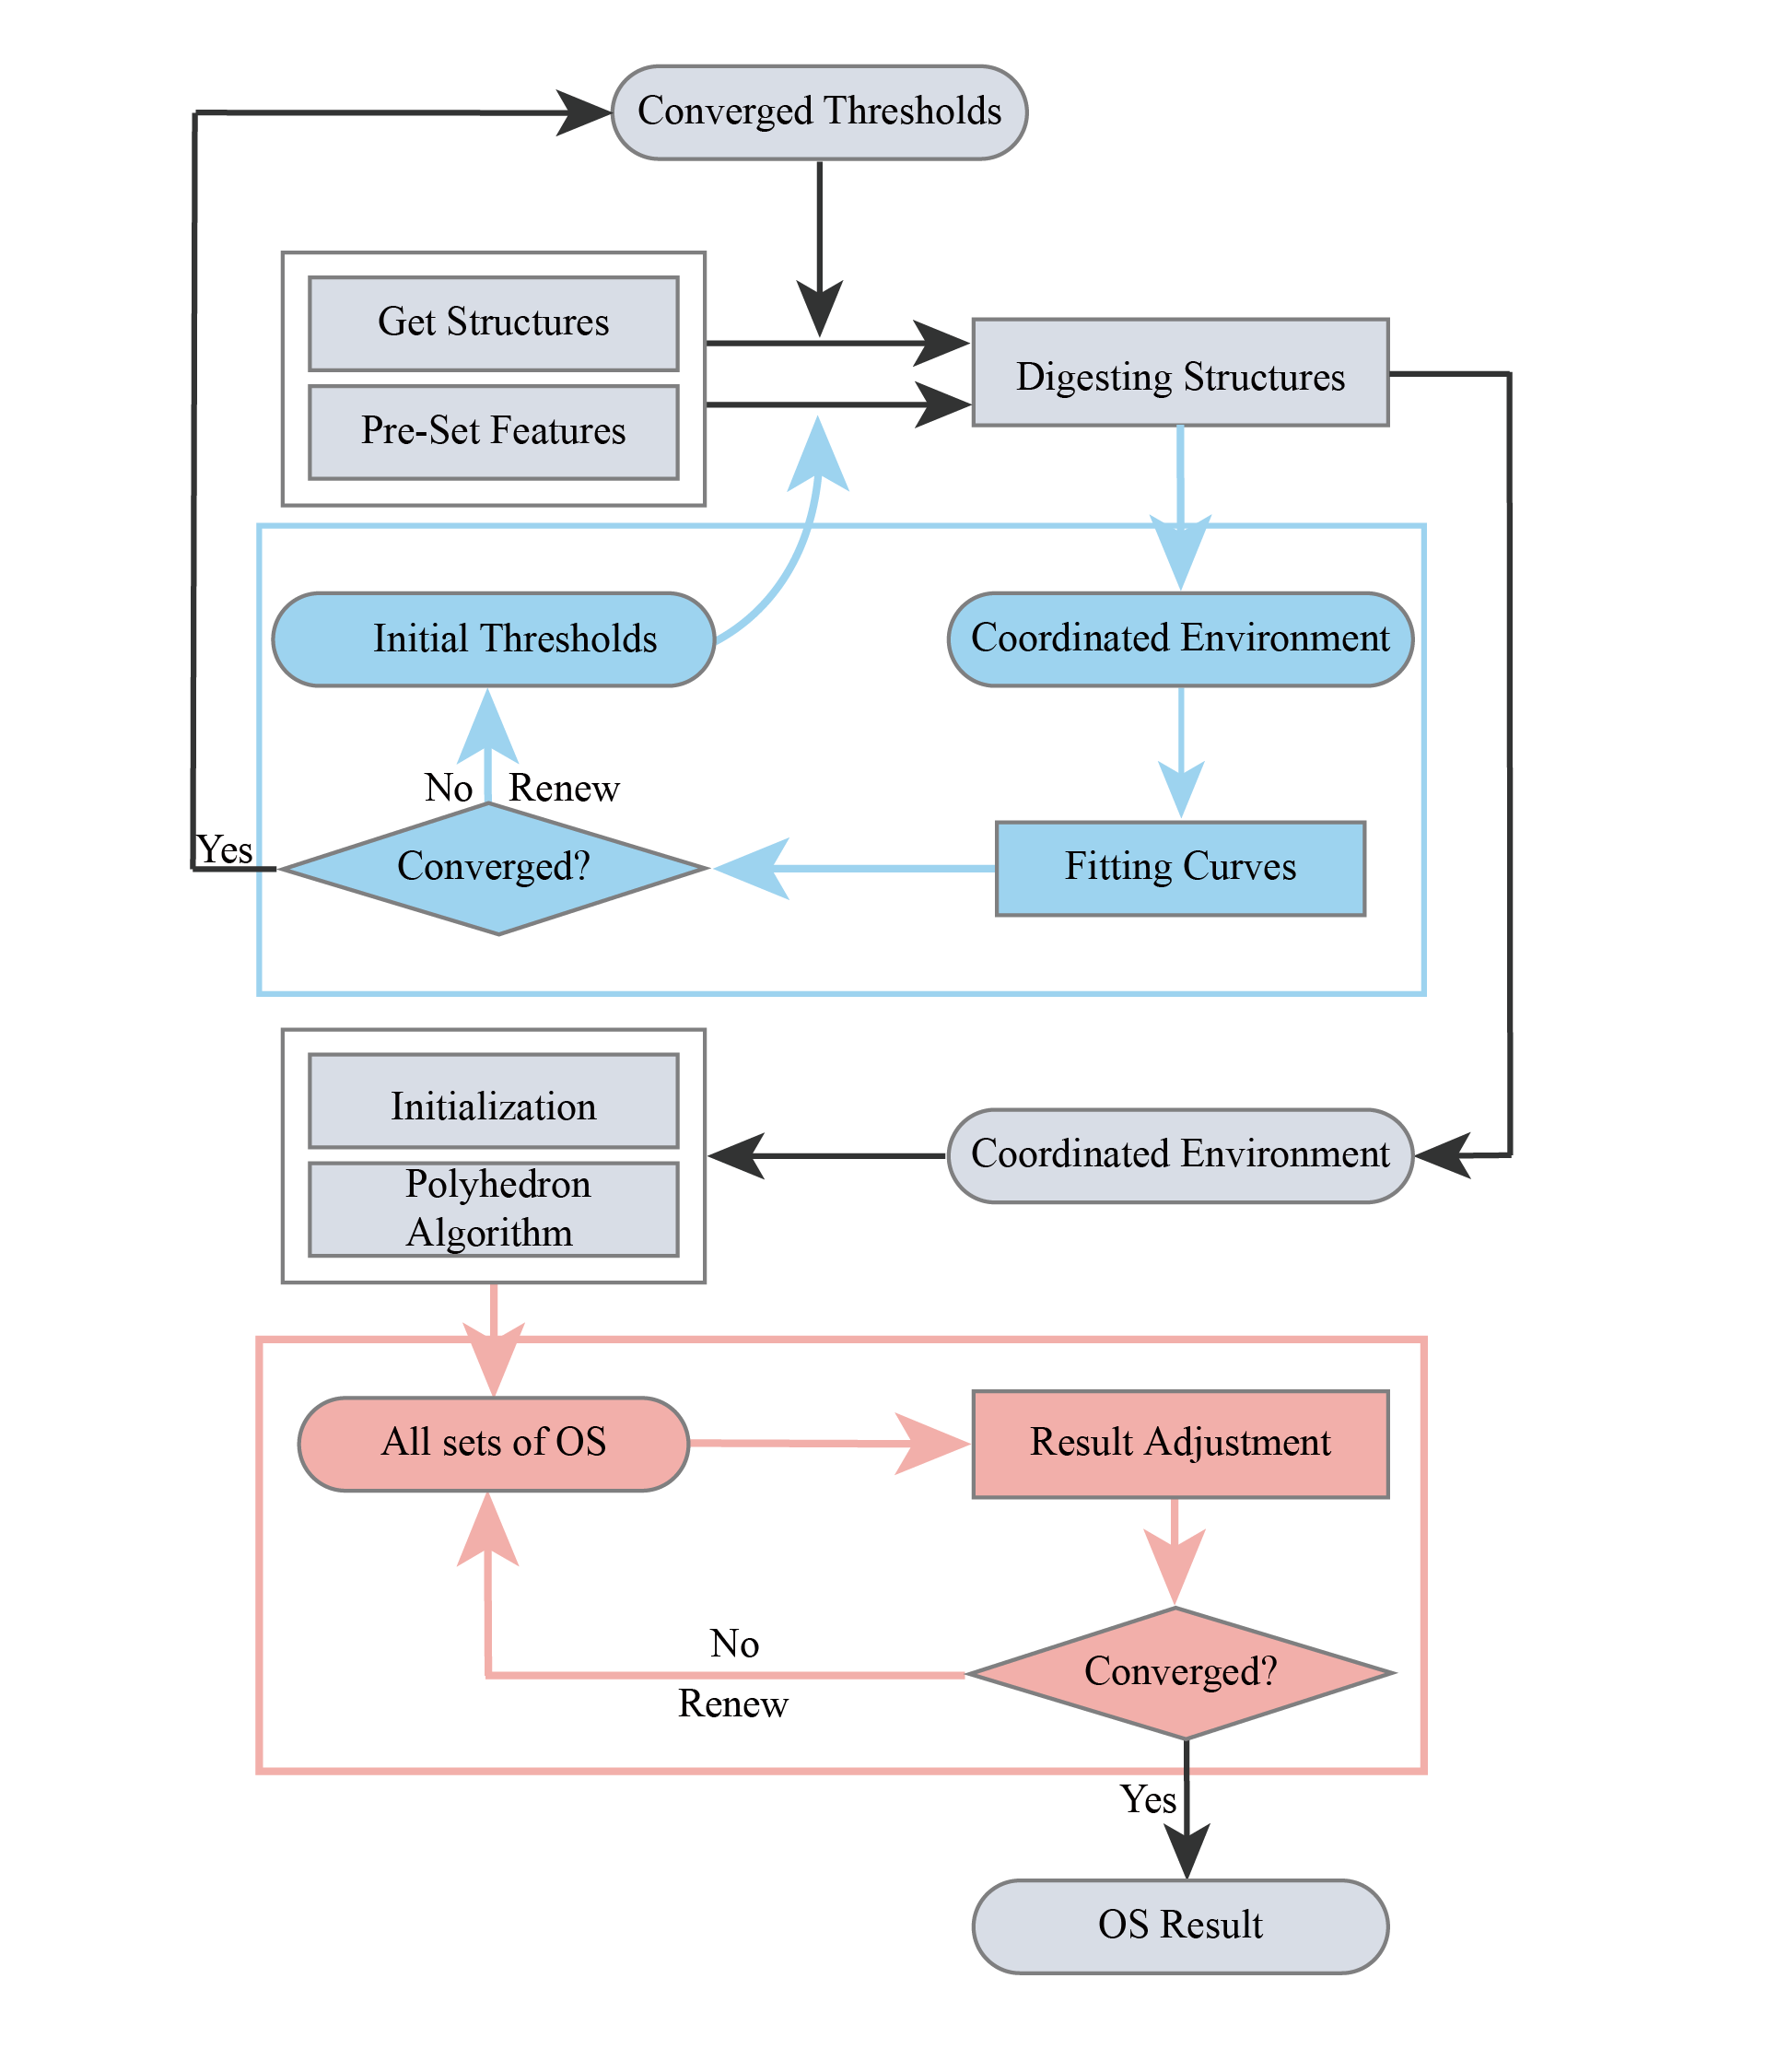

In [90]:
from IPython.display import Image, display
png_file_path = 'Fig_1.png'
display(Image(png_file_path))

# Fig.2

In [6]:
import pandas as pd
import numpy as np
import pickle
from scipy.optimize import curve_fit

OV = pd.read_csv("../redefined_length_csv/bond_of_O_V.csv", header=None)[0].tolist()
OAl = pd.read_csv("../redefined_length_csv/bond_of_O_Al.csv", header=None)[0].tolist()

with open("../fitting_info_dict.pkl", "rb") as f:
    fitting_info = pickle.load(f)


def refine_data(Min, Max, step, target_list):
    stations = np.arange(Min, Max + step, step)
    stations = np.round(stations, 3)
    def find_station(value):
        station_indices = np.searchsorted(stations, value, side='right') - 1
        return stations[max(station_indices, 0)]
    processed_list = [find_station(value) for value in target_list]
    return processed_list

def length_2_distribution(length, t):
    length = [l for l in length if t >= l > 0.1]
    Min, Max = min(length), max(length)
    Step = round(((Max-Min)/50),3)
    refined_distance = refine_data(Min, Max, Step, length)
    unique_values, counts = np.unique(refined_distance, return_counts=True)
    return unique_values, counts/sum(counts)


class GaussianModel:
    def __init__(self, num_gaussians):
        self.num_gaussians = num_gaussians

    def gaussian(self, x, *params):
        y = np.zeros_like(x)
        for i in range(self.num_gaussians):
            amplitude = params[i*3]
            mean = params[i*3+1]
            stddev = params[i*3+2]
            y += amplitude * np.exp(-((x - mean) ** 2) / (2 * (stddev ** 2)))
        return y

    def fit(self,x,y,means,sigmas):
        initial_guesses = []
        lower_bounds = []
        upper_bounds = []
        for mean,sigma in zip(means,sigmas):
            initial_guesses.extend([0.2, mean, sigma])
            lower_bounds.extend([0, mean-0.001, sigma-0.001])
            upper_bounds.extend([1, mean+0.001, sigma+0.001])

        bounds = (lower_bounds, upper_bounds)
        popt, _ = curve_fit(self.gaussian, x, y, p0=initial_guesses, bounds=bounds)
        y_pred = [self.gaussian(X, *popt) for X in x]
        self.popt = popt
        return popt,y_pred
    
    def single_fit(self,x):
        return self.gaussian(x, *self.popt)
        

1.757 1.895 0.022 0.065
1.722 1.995 0.059 0.1


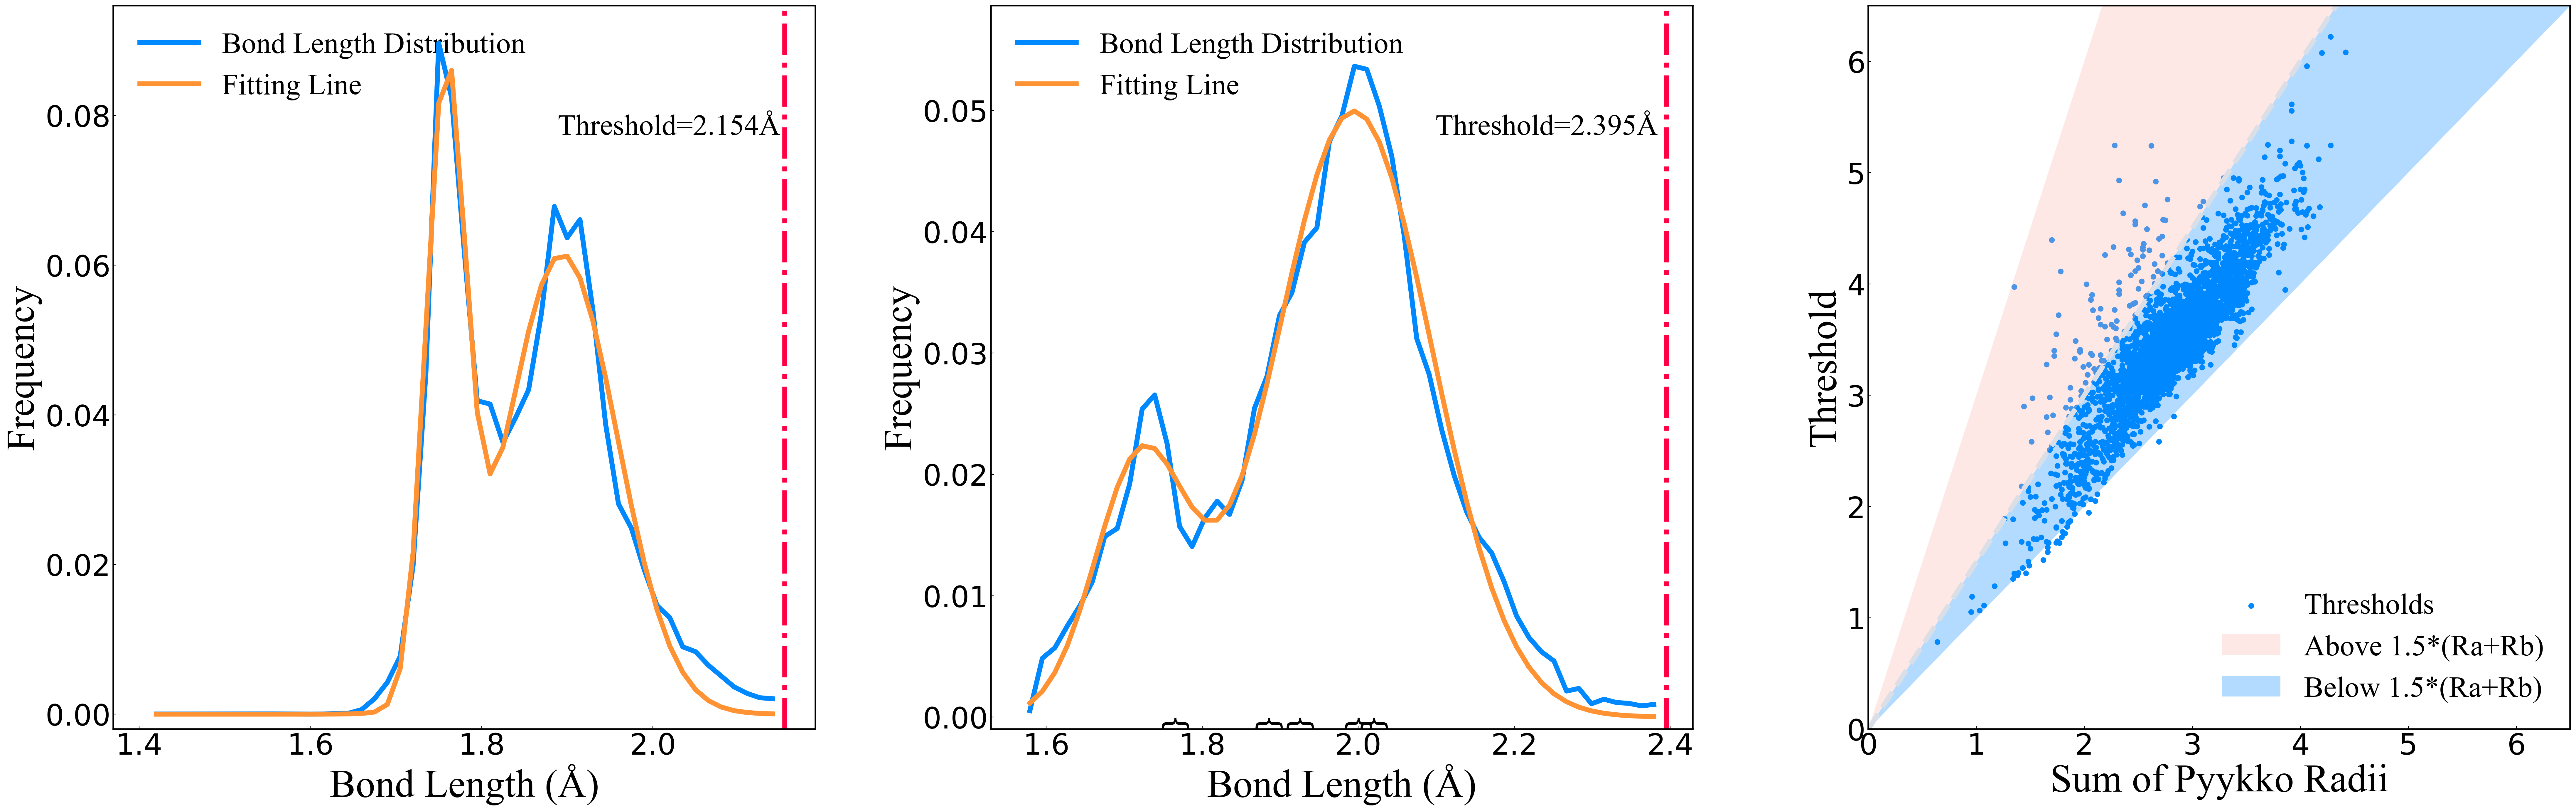

In [179]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

###
OV_lines = {"V5O4":(1.75,1.77),"V5O5":(1.84,1.92),"V5O6":(1.89,1.95),"V4O6":(1.97,2.02),"V3O6":(1.99,2.04)}
OAl_lines = {"Al3O6":(1.757),"Al3O4":(1.895)}
###

fig,gs = plt.figure(figsize=(54,16), dpi=200), GridSpec(1,3)
ax1,ax2,ax4 = plt.subplot(gs[0:1,0:1]),plt.subplot(gs[0:1,1:2]),plt.subplot(gs[0:1,2:3])
GM = GaussianModel(2)

title_size = 60
label_size = 48
legend_size = 36
tick_size = 36
line_size = 6
text_size = 36



# PLOT ONE ###################################
r2,mean1,sigma1,mean2,sigma2,threshold = fitting_info[("O", "Al")].values()
print(mean1,mean2,sigma1,sigma2)
x,y = length_2_distribution(OAl, threshold)
popt, y_pred = GM.fit(x,y,[mean1,mean2],[sigma1,sigma2])
ax1.plot(x,y, linewidth=line_size, c="#0088FF", label="Bond Length Distribution")
ax1.plot(x, y_pred, linewidth=line_size, c="#FF9333", label="Fitting Line")
ax1.axvline(x=threshold, linestyle="-.",c="#FF0044", linewidth=line_size)#, label="Threshold")
ax1.text(0.95, 0.85, 'Threshold=%sÅ'%threshold, fontsize=text_size, fontname='Times New Roman', ha='right', va='top', transform=ax1.transAxes)

for se_coords in OAl_lines.values():
    avg_x = np.average(se_coords)
    #ax2.plot([avg_x,avg_x], [0, GM.single_fit(avg_x)*0.7], linestyle=":", c="black", linewidth=line_size)

ax1.tick_params(axis='x', labelsize=tick_size)
ax1.tick_params(axis='y', labelsize=tick_size)
ax1.set_xlim([min(x)-0.05,max(x)+0.05])
ax1.set_ylim([-0.002,max(y)+0.005])
#ax2.set_title("Bond Length Distribution for O-Al", fontsize=title_size, fontname='Times New Roman')
ax1.set_xlabel("Bond Length (Å)", fontsize=label_size, fontname='Times New Roman')
ax1.set_ylabel("Frequency", fontsize=label_size, fontname='Times New Roman')
#ax2.legend(loc='upper right', prop={'size': legend_size}, bbox_to_anchor=(0.95, 1.0))
legend1 = ax1.legend(loc='upper left', prop={'size': legend_size, 'family': 'Times New Roman'}, frameon=False)
legend1.set_zorder(1)



# PLOT TWO #####################################
r2,mean1,sigma1,mean2,sigma2,threshold = fitting_info[("O", "V")].values()
print(mean1,mean2,sigma1,sigma2)
x,y = length_2_distribution(OV, threshold)
popt, y_pred = GM.fit(x,y,[mean1,mean2],[sigma1,sigma2])
ax2.plot(x,y, linewidth=line_size, c="#0088FF", label="Bond Length Distribution")
ax2.plot(x, y_pred, linewidth=line_size, c="#FF9333", label="Fitting Line")
ax2.axvline(x=threshold, linestyle="-.",c="#FF0044", linewidth=line_size)#, label="Threshold")
ax2.text(0.95, 0.85, 'Threshold=%sÅ'%threshold, fontsize=text_size, fontname='Times New Roman', ha='right', va='top', transform=ax2.transAxes)

for se_coords in OV_lines.values():
    avg_x = np.average(se_coords)
    #ax1.plot([avg_x,avg_x], [0, GM.single_fit(avg_x)*0.7], linestyle=":", c="black", linewidth=line_size)
    ax2.text(avg_x, 0, '{', fontsize=text_size, rotation=-90, ha='center', va='top')

ax2.tick_params(axis='x', labelsize=tick_size)
ax2.tick_params(axis='y', labelsize=tick_size)
ax2.set_xlim([min(x)-0.05,max(x)+0.05])
ax2.set_ylim([-0.001,max(y)+0.005])
#ax1.set_title("Bond Length Distribution for O-V", fontsize=title_size, fontname='Times New Roman')
ax2.set_xlabel("Bond Length (Å)", fontsize=label_size, fontname='Times New Roman')
ax2.set_ylabel("Frequency", fontsize=label_size, fontname='Times New Roman')
#ax1.legend(loc='upper right', prop={'size': legend_size}, bbox_to_anchor=(0.95, 1.0))
legend2 = ax2.legend(loc='upper left', prop={'size': legend_size, 'family': 'Times New Roman'}, frameon=False)
legend2.set_zorder(1)



#PLOT FOUR
openexcel = pd.read_excel('../pre_set.xlsx', sheet_name = "Radii_X") 
dic_s = openexcel.set_index("symbol").to_dict()["single"]
pyykko_list, threshold_list = [], []
for k,v in fitting_info.items():
    threshold_list.append(v["threshold"])
    pyykko_list.append(np.array(dic_s[k[0]]+dic_s[k[1]])*0.01)
pyykko_list, threshold_list = np.array(pyykko_list), np.array(threshold_list)
b = np.linspace(0, 7, 100)
ax4.scatter(pyykko_list, threshold_list, color='#0088FF', label='Thresholds', alpha=1)
plt.fill([0, 7, 7/2], [0, 7*1.5, 7*1.5], color='#F9B3AD', alpha=0.3, label='Above 1.5*(Ra+Rb)', linewidth=0) 
plt.fill([0, 7, 7], [0, 7, 7*1.5], color='#0088FF', alpha=0.3, label='Below 1.5*(Ra+Rb)', linewidth=0) 
#ax4.plot([0, 7], [0, 7], linestyle='--', color='#D9DEE7', linewidth=line_size)
ax4.plot([0, 7], [0, 10.5], linestyle='--', color='#D9DEE7', linewidth=line_size)

ax4.tick_params(axis='x', labelsize=tick_size)
ax4.tick_params(axis='y', labelsize=tick_size)
ax4.set_xlim([0,6.5])
ax4.set_ylim([0,6.5])
#ax4.set_title("Comparison of Pyykko Radii to Thresholds", fontsize=title_size, fontname='Times New Roman')
ax4.set_xlabel("Sum of Pyykko Radii", fontsize=label_size, fontname='Times New Roman')
ax4.set_ylabel("Threshold", fontsize=label_size, fontname='Times New Roman')
ax4.legend(loc='lower right', prop={'size': legend_size, 'family': 'Times New Roman'}, frameon=False)

for ax in [ax1, ax2, ax4]:
    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(2)  # Set linewidth to make the axes bold

plt.subplots_adjust(wspace=0.25)
plt.savefig("Fig_2.jpg")

# Fig.3

In [15]:
import json
import pickle
import numpy as np

file_get = open("../fitting_info_dict.pkl",'rb') 
fitting_info_dict = pickle.load(file_get) 
file_get.close()


element_list = ['H' ,                                                                                                 'He', 
                'Li', 'Be',                                                             'B' , 'C' , 'N' , 'O' , 'F' , 'Ne', 
                'Na', 'Mg',                                                             'Al', 'Si', 'P' , 'S' , 'Cl', 'Ar', 
                'K' , 'Ca', 'Sc', 'Ti', 'V' , 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 
                'Rb', 'Sr', 'Y' , 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I' , 'Xe', 
                'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 
                                  'Hf', 'Ta', 'W' , 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn',
                'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U' , 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr',
                                  'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn', 'Nh', 'Fl', 'Mc', 'Lv', 'Ts', 'Og']


np_element = np.array([
"H"   ,"None","None","None","None","None","None","None","None","None","None","None","None","None","None","None","None","He"  , 
"Li"  ,"Be"  ,"None","None","None","None","None","None","None","None","None","None","B"   ,"C"   ,"N"   ,"O",   "F"   ,"Ne"  ,
"Na"  ,"Mg"  ,"None","None","None","None","None","None","None","None","None","None","Al"  ,"Si"  ,"P"   ,"S"   ,"Cl"  ,"Ar"  , 
"K"   ,"Ca"  ,"Sc"  ,"Ti"  ,"V"   ,"Cr"  ,"Mn"  ,"Fe"  ,"Co"  ,"Ni"  ,"Cu"  ,"Zn"  ,"Ga"  ,"Ge"  ,"As"  ,"Se"  ,"Br"  ,"Kr"  ,
"Rb"  ,"Sr"  ,"Y"   ,"Zr"  ,"Nb"  ,"Mo"  ,"Tc"  ,"Ru"  ,"Rh"  ,"Pd"  ,"Ag"  ,"Cd"  ,"In"  ,"Sn"  ,"Sb"  ,"Te"  ,"I"   ,"Xe"  , 
"Cs"  ,"Ba"  ,"None","Hf"  ,"Ta"  ,"W"   ,"Re"  ,"Os"  ,"Ir"  ,"Pt"  ,"Au"  ,"Hg"  ,"Tl"  ,"Pb"  ,"Bi"  ,"Po"  ,"At"  ,"Rn",
"Fr"  ,"Ra"  ,"None","Rf"  ,"Db"  ,"Sg"  ,"Bh"  ,"Hs"  ,"Mt"  ,"Ds"  ,"Rg"  ,"Cn"  ,"Nh"  ,"Fl"  ,"Mc"  ,"Lv"  ,"Ts"  ,"Og",
"None","None","None","None","None","None","None","None","None","None","None","None","None","None","None","None","None","None",
"None","None","La"  ,"Ce"  ,"Pr"  ,"Nd"  ,"Pm"  ,"Sm"  ,"Eu"  ,"Gd"  ,"Tb"  ,"Dy"  ,"Ho"  ,"Er"  ,"Tm"  ,"Yb"  ,"Lu"  ,"None",
"None","None","Ac"  ,"Th"  ,"Pa"  ,"U"   ,"Np"  ,"Pu"  ,"Am"  ,"Cm"  ,"Bk"  ,"Cf"  ,"Es"  ,"Fm"  ,"Md"  ,"No"  ,"Lr"  ,"None"])

with open('../toss_page/specie_finder/without_Alloys_specie_parameters.json', 'r') as file:
    specie_dict = json.load(file)

    
chosen_ele_dict = {}
for ele in element_list:
    if ele in specie_dict:
        chosen_ele_dict[ele] = sorted(specie_dict[ele], key=lambda x:x["N"])[-1]

In [16]:
np_color = np.array(["gr",  0.0, 0.0,  0.0,   0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0, 0.0,   0.0,  0.0,  0.0,  0.0, "gr", 
                     "bl", "bl", 0.0,  0.0,   0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0, "bl", "bl", "gr", "gr", "gr", "gr",
                     "bl", "bl", 0.0,  0.0,   0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0, "bl", "bl", "bl", "bl", "gr", "gr", 
                     "bl", "bl", "bl", "bl", "bl", "bl", "bl", "bl", "bl", "bl", "bl", "bl", "bl", "bl", "bl", "bl", "gy", "gr",
                     "bl", "bl", "bl", "bl", "bl", "bl", "pr", "bl", "bl", "bl", "bl", "bl", "bl", "bl", "bl", "bl", "bl", "gr", 
                     "bl", "bl",  0.0, "bl", "bl", "bl", "bl", "bl", "bl", "bl", "bl", "gy", "bl", "bl", "bl", "bl", "bl", "gr",
                     "bl", "bl",  0.0, "pr", "pr", "pr", "pr", "pr", "pr", "pr", "pr", "pr", "pr", "pr", "pr", "pr", "pr", "gr",
                      0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0  ,0.0,  0.0,  0.0, 0.0,   0.0,  0.0,
                      0.0,  0.0, "bl", "bl", "bl", "bl", "pr", "bl", "bl", "bl", "bl", "bl", "bl", "bl", "bl", "bl", "bl",  0.0,
                      0.0,  0.0, "bl", "bl", "bl", "bl", "pr", "pr", "pr", "pr", "pr", "pr", "pr", "pr", "pr", "pr", "pr",  0.0])

color_dict = {"gr":"#FFFFE0","pr":"#D8BFD8","bl":"#ADD8E6","gy":"#D3D3D3","none":"#D3D3D3"}
html_color = list(map(lambda x:color_dict[x], list(map(lambda x:x if x!="0.0" else "none", np_color))))

In [43]:
elements_const = {}
for i,e in enumerate(np_element):
    if e != 'None':
        edict = {}
        edict["CN"] = "%s"%chosen_ele_dict[e]["CN"] if e in chosen_ele_dict else ""
        edict["OS"] = "%s"%chosen_ele_dict[e]["OS"] if e in chosen_ele_dict else ""
        edict["R"] = "%.3f"%chosen_ele_dict[e]["R"] if e in chosen_ele_dict else "No Data"
        edict["S"] = "%.3f"%chosen_ele_dict[e]["S"] if e in chosen_ele_dict else ""
        edict["N"] = "%s"%chosen_ele_dict[e]["N"] if e in chosen_ele_dict else ""
        if edict["R"] == "No Data":
            edict["color"] = "#D9DEE7"#"#D3D3D3"
        else:
            if int(edict["OS"]) < 0:
                edict["color"] = "#F9B3AD"#"#D8BFD8"
            if int(edict["OS"]) > 0:
                edict["color"] = "#9FDAF7"#"#ADD8E6"
            if int(edict["OS"]) == 0:
                edict["color"] = "#EDC66A"#"#FFFFE0"
        edict["AN"] = element_list.index(e)+1
        elements_const[e] = edict

In [188]:
elements_const["Lr"]

{'CN': '',
 'OS': '',
 'R': 'No Data',
 'S': '',
 'N': '',
 'color': '#D9DEE7',
 'AN': 103}

In [193]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(54, 30), dpi=200, facecolor="white")
gs = gridspec.GridSpec(10, 18, wspace=0.05, hspace=0.05) 
fig.tight_layout(pad=0)

plt.axis('off')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'


ele_size = 60
OSCN_size = 48
R_size = 36
S_size = 24
n_size = 24


for i in range(10*18):
    if np_element[i] != "None":
        ele =  np_element[i]
        color = elements_const[ele]["color"]
        CN = elements_const[ele]["CN"]
        OS = elements_const[ele]["OS"]

        if OS:
            OS = f"{int(OS):+2d}" if int(OS) != 0 else f"{int(OS):2d}"
        else:
            OS = "  "

        R = elements_const[ele]["R"]
        S = elements_const[ele]["S"]
        N = elements_const[ele]["N"]
        AN = elements_const[ele]["AN"]

        ax = fig.add_subplot(gs[i])
        ax.patch.set_facecolor(color)
        ax.set(xlim=[0, 1], ylim=[0, 1], xticks=[], yticks=[])
        for spine in ['right', 'top', 'left', 'bottom']:
            ax.spines[spine].set_visible(False)
        
        if R != "No Data":
            #ele_OS_CN = f"${ele}_{{\mathrm{{%s}}}}^{{\mathrm{{%s}}}}$"%(CN,OS)
            ax.text(x=0.4, y=0.5, s=ele, fontsize=ele_size, ha='center', fontweight='bold')
            ax.text(x=0.9, y=0.75, s=OS, fontsize=OSCN_size, ha='right',fontweight='bold')
            ax.text(x=0.9, y=0.35, s=CN, fontsize=OSCN_size, ha='right',fontweight='bold')
            ax.text(x=0.5, y=0.18, s=R, fontsize=R_size, ha='center')
            ax.text(x=0.5, y=0.06, s=S, fontsize=S_size, ha='center') 
        else:
            ax.text(x=0.5, y=0.55, s=ele, fontsize=ele_size, ha='center', fontweight='bold')
            ax.text(x=0.5, y=0.10, s=R, fontsize=R_size, ha='center')
        ax.text(x=0.02, y=0.98, s=str(AN), fontsize=n_size, ha='left',va='top', fontweight='bold')
        
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)

#plt.axis('off')
plt.show()
fig.savefig("species_periodic_table.svg")

# Fig.4

In [ ]:
import sys
import os
sys.path.append("../toss_GNN/")
from model_utils_pyg import *
from dataset_utils_pyg import *
from data_utils import *
from torch_geometric.loader import DataLoader as PYG_DataLoader
from sklearn import metrics
import plotly.graph_objects as go

#### Node Classification

In [ ]:
if not os.path.exists("NC_CM.pkl"):
    pyg_GCN_s = pyg_GCNPredictor(in_feats=15, hidden_feats=[256, 256, 256, 256], 
                                 activation=None, residual=None, batchnorm=None, dropout=None, 
                                 predictor_hidden_feats=64, n_tasks=12, predictor_dropout=0.3) 
    pyg_GCN_s.load_state_dict(torch.load("../models/pyg_GCN_s_0512.pth"))
    dataset = TOSS_PYG_NC_MEF_DataSet(root="../").shuffle() 
    data_loader = PYG_DataLoader(dataset, batch_size=50, shuffle=True, collate_fn=PYG_NC_collate, drop_last = False)

    model = pyg_GCN_s
    model.eval()
    eval_matrix = measure_matrix()

    with torch.no_grad():
        for batch_id, batch_data in enumerate(data_loader):
            batch_data = batch_data.to('cuda:0')
            labels = batch_data.y.to('cuda:0')

            model = model.to("cuda:0")

            outputs = model(batch_data)

            torch.cuda.empty_cache()
            masks = torch.ones(labels.shape)
            eval_matrix.update(outputs, labels, masks)
        abs_score = eval_matrix.absolute_correct_rate() *  100

    all_true = np.vstack((eval_matrix.y_true))
    all_pred = np.vstack((eval_matrix.y_pred))

    def unencode(l):
        l = list(l)
        classes=["-4","-3","-2","-1","0","1","2","3","4","5","6","7"]
        return classes[l.index(max(l))]

    ALL_PRED = list(map(unencode, all_pred))
    ALL_TRUE = list(map(unencode, all_true))
    
    NC_CM = metrics.confusion_matrix(ALL_PRED, ALL_TRUE, normalize="true")

    file_save = open("NC_CM.pkl",'wb') 
    pickle.dump(NC_CM, file_save) 
    file_save.close()
    
else:
    file_get = open("NC_CM.pkl", 'rb') 
    NC_CM = pickle.load(file_get) 
    file_get.close()

#### Link Prediction

In [ ]:
if not os.path.exists("LP_CM.pkl"):
    pyg_Hetero_GCN_s = pyg_Hetero_GCNPredictor(atom_feats=13, bond_feats=13, hidden_feats=[256,256,256,256], 
                                               activation=None, residual=None, batchnorm=None, dropout=None,
                                               predictor_hidden_feats=64, n_tasks=2,predictor_dropout=0.3)

    pyg_Hetero_GCN_s.load_state_dict(torch.load("../models/pyg_Hetero_GCN_s_0515.pth"))
    dataset = TOSS_PYG_LP_FN_DataSet(root="../").shuffle()
    data_loader = PYG_DataLoader(dataset, batch_size=100, shuffle=True, drop_last=True, collate_fn=PYG_NC_collate)  

    model = pyg_Hetero_GCN_s
    model.eval()
    eval_matrix = measure_matrix()

    with torch.no_grad():
        for batch_id, batch_data in enumerate(data_loader):
            batch_data = batch_data.to('cuda:0')
            labels = batch_data.y.to('cuda:0')
            model = model.to("cuda:0")

            outputs = model(batch_data)

            torch.cuda.empty_cache()
            masks = torch.ones(labels.shape)
            eval_matrix.update(outputs, labels, masks)
        abs_score = eval_matrix.absolute_correct_rate() *  100

    all_true = np.vstack((eval_matrix.y_true))
    all_pred = np.vstack((eval_matrix.y_pred))

    def unencode(l):
        l = list(l)
        classes=["True", "False"]
        return classes[l.index(max(l))]

    ALL_PRED = list(map(unencode, all_pred))
    ALL_TRUE = list(map(unencode, all_true))
    
    LP_CM = metrics.confusion_matrix(ALL_PRED, ALL_TRUE, normalize="true")

    file_save = open("LP_CM.pkl",'wb') 
    pickle.dump(LP_CM, file_save) 
    file_save.close()
    
else:
    file_get = open("LP_CM.pkl", 'rb') 
    LP_CM = pickle.load(file_get) 
    file_get.close()

#### Main Plot

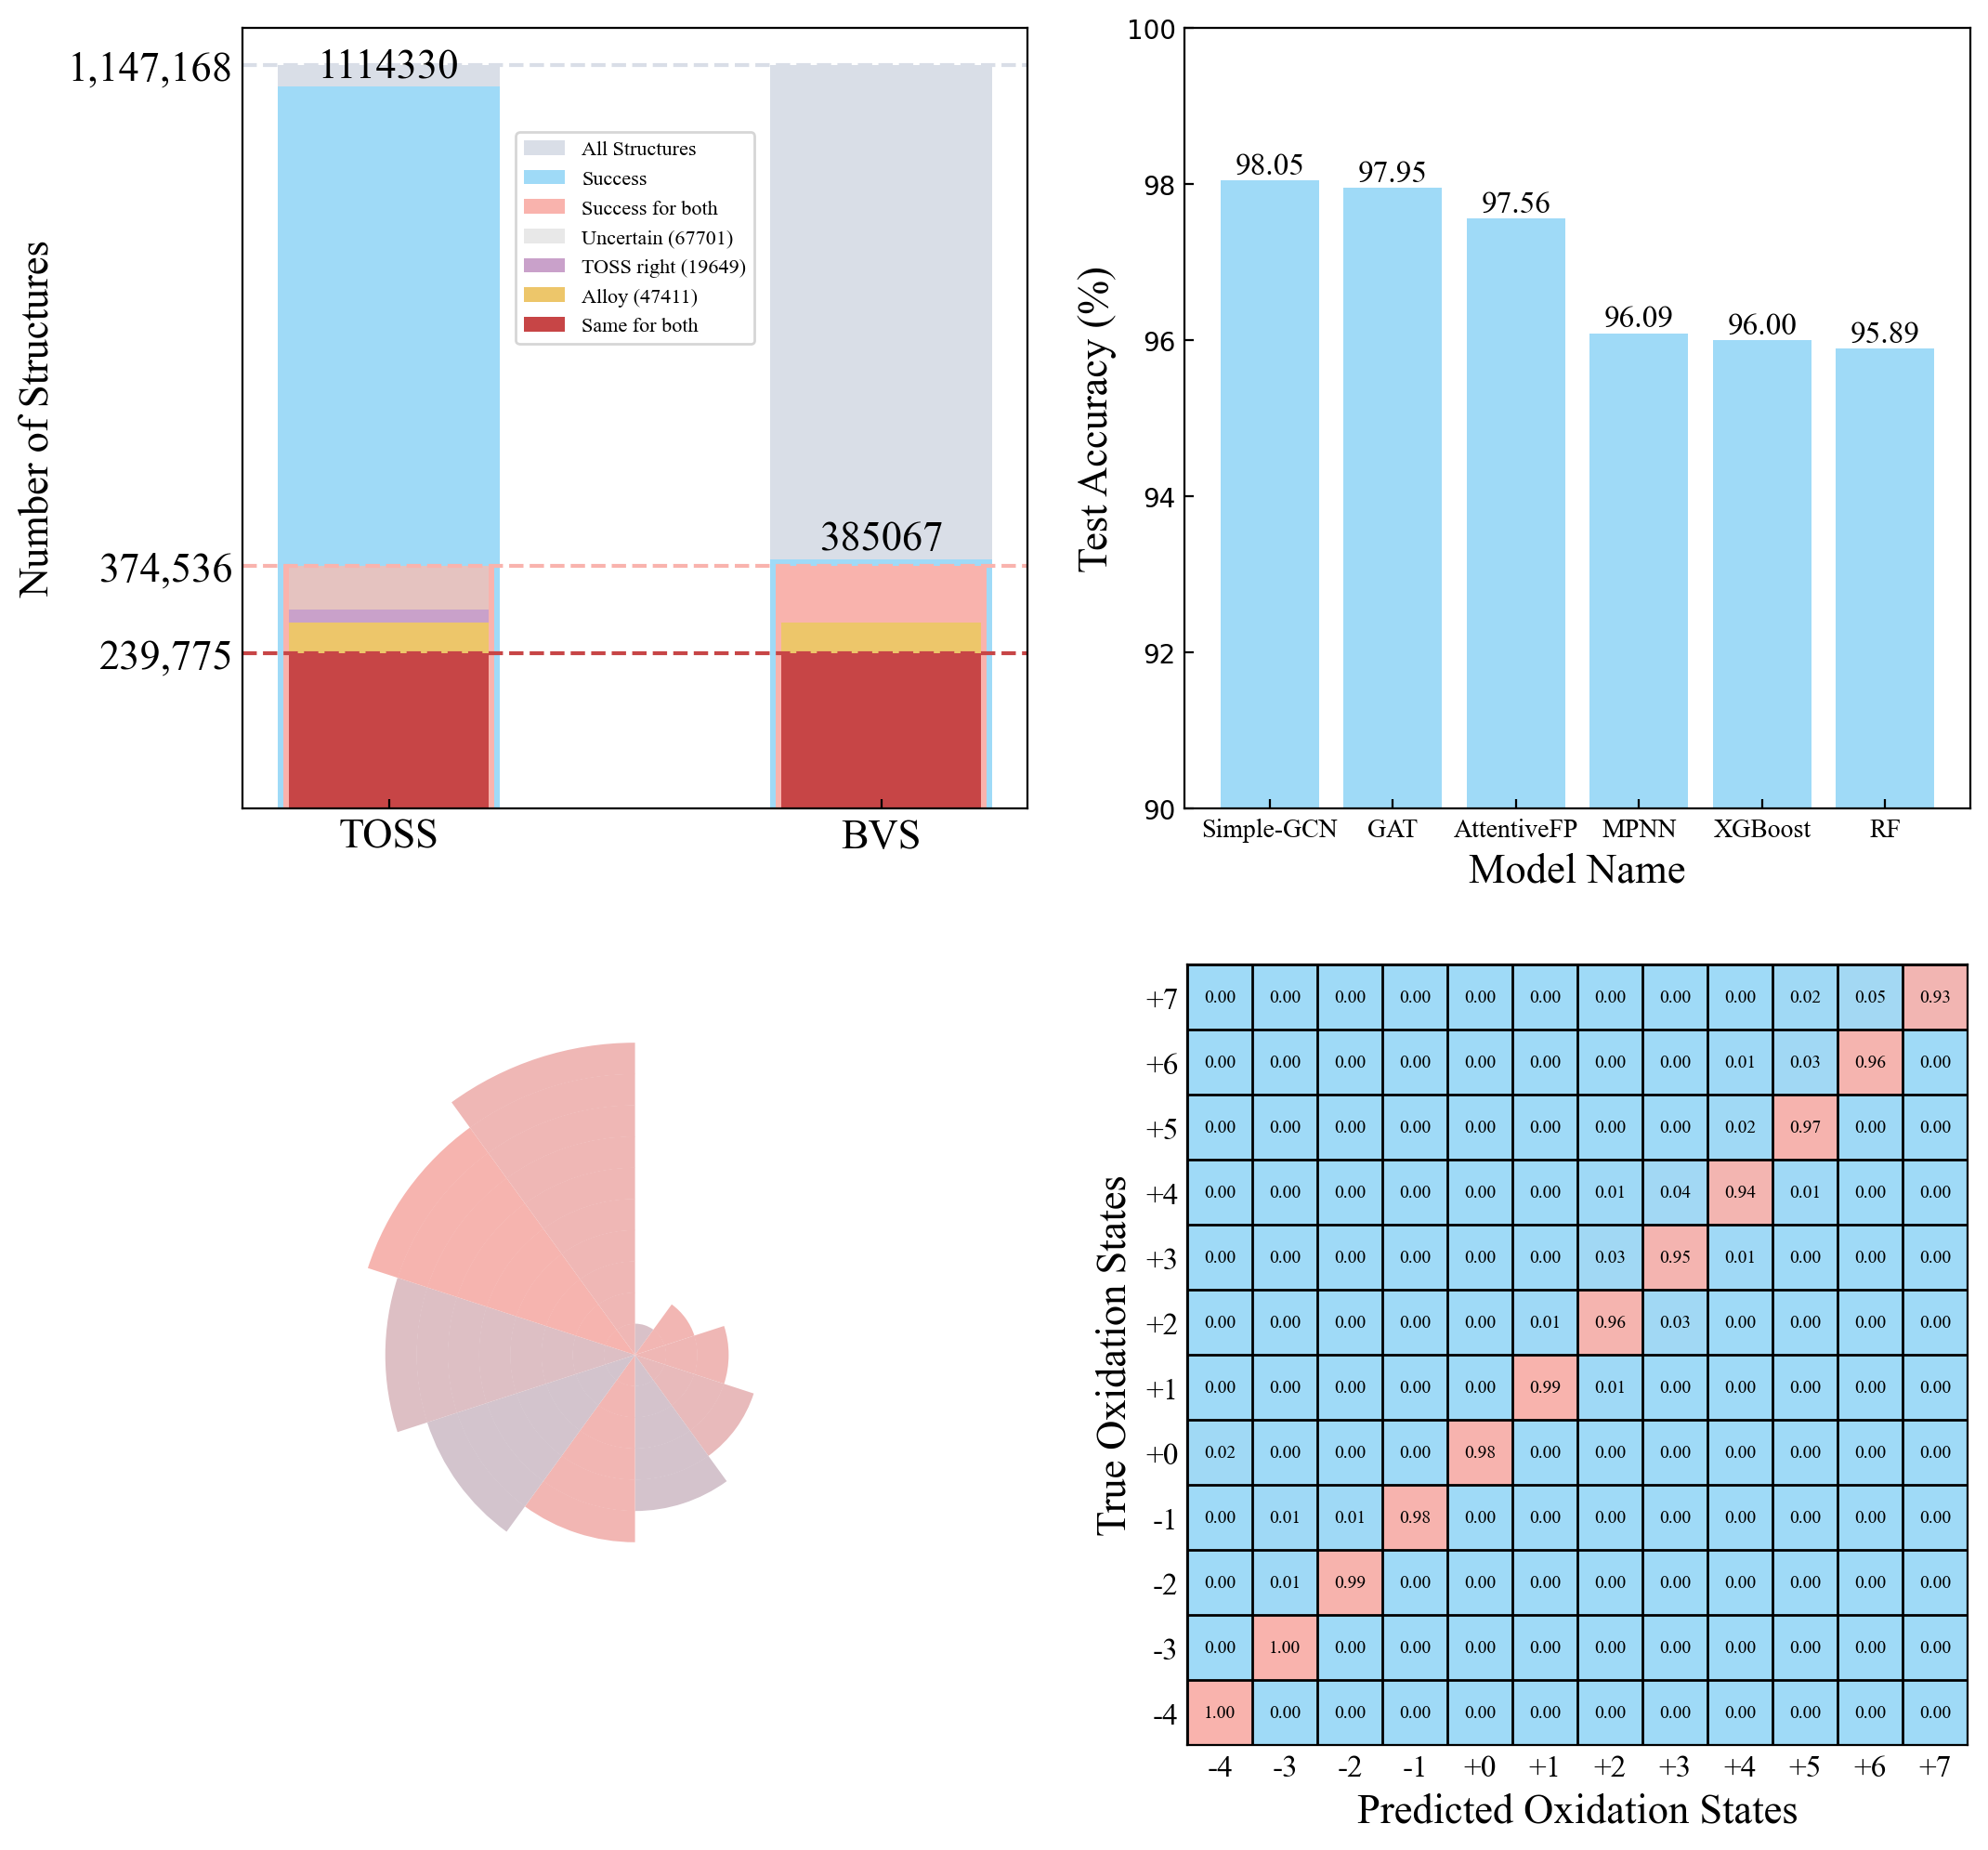

In [424]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize

fig, gs = plt.figure(figsize=(12, 12), dpi=200), GridSpec(2, 2)
ax1, ax2, ax3, ax4 = plt.subplot(gs[0:1, 0:1]), plt.subplot(gs[0:1, 1:2]), plt.subplot(gs[1:2, 0:1]), plt.subplot(gs[1:2, 1:2])



# Fig ONE!
stat = {"total":1147168,"toss":1114330,"BVS":385067,"both":374536,"same":239775,"right":8525+11124,"uncertain":13225+25168+29308,"alloy":47411}
assert stat["both"] == stat["uncertain"] + stat["same"] + stat["right"] + stat["alloy"]

bar_width = 0.45
text_size = 16
label_size = 16
legend_size = 8

###
index=0
ax1.bar(index, stat["total"], bar_width, label='All Structures', color="#D9DEE7")
ax1.bar(index, stat["toss"], bar_width, label='Success', color="#9FDAF7")
ax1.bar(index, stat["both"], bar_width*0.95, label='Success for both', color="#F9B3AD")
ax1.bar(index, stat["uncertain"], bar_width*0.90, bottom=stat["alloy"]+stat["same"]+stat["right"], label="Uncertain (%s)"%stat["uncertain"], color="lightgray", alpha=0.5)
ax1.bar(index, stat["right"], bar_width*0.90, bottom=stat["alloy"]+stat["same"], label='TOSS right (%s)'%stat["right"], color="#C9A1CA")
ax1.bar(index, stat["alloy"], bar_width*0.90, bottom=stat["same"], label='Alloy (%s)'%stat["alloy"], color="#EDC66A")
ax1.bar(index, stat["same"], bar_width*0.90, label='Same for both', color="#C74546")
ax1.text(x=index, y=stat["toss"], s=str(stat["toss"]), fontsize=text_size, ha='center', va='bottom', fontname='Times New Roman')

index=1
ax1.bar(index, stat["total"], bar_width, color="#D9DEE7")
ax1.bar(index, stat["BVS"], bar_width, color="#9FDAF7")
ax1.bar(index, stat["both"], bar_width*0.95, color="#F9B3AD")
ax1.bar(index, stat["alloy"], bar_width*0.90, bottom=stat["same"], color="#EDC66A")
ax1.bar(index, stat["same"], bar_width*0.90,  color="#C74546")
ax1.text(x=index, y=stat["BVS"], s=str(stat["BVS"]), fontsize=text_size, ha='center', va='bottom', fontname='Times New Roman')

ax1.axhline(y=stat["total"], color="#D9DEE7", linestyle='--')
#ax1.text(x=0.5, y=stat["total"], s=str(stat["total"]), fontsize=text_size, ha='center', va='bottom', fontweight='bold', fontname='Times New Roman')
ax1.axhline(y=stat["both"], color="#F9B3AD", linestyle='--')
#ax1.text(x=0.5, y=stat["both"], s=str(stat["both"]), fontsize=text_size, ha='center', va='bottom', fontweight='bold', fontname='Times New Roman')
ax1.axhline(y=stat["same"], color="#C74546", linestyle='--')
#ax1.text(x=0.5, y=stat["same"], s=str(stat["same"]), fontsize=text_size, ha='center', va='bottom', fontweight='bold', fontname='Times New Roman')
##

ax1.set_ylim([0, stat["total"]*1.05])
ax1.set_yticks([1147168, 374536, 239775], fontsize=label_size, fontname='Times New Roman')
ax1.set_ylabel('Number of Structures', fontsize=label_size, fontname='Times New Roman')
ax1.set_yticklabels(ax1.get_yticks(), fontdict={'family': 'Times New Roman', 'size': label_size})

ax1.set_xticks([0,1])
ax1.set_xticklabels(["TOSS", "BVS"], fontsize=label_size, fontname='Times New Roman')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 0.88), prop={'size': legend_size, 'family': 'Times New Roman'})

ax1.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False))
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))



# Fig TWO!
label_size = 16
tick_size = 10
string_size = 12

acc = {"Simple-GCN":98.05, "GAT":97.95, "AttentiveFP":97.56, "MPNN":96.09, "XGBoost":96.00, "RF":95.89}
x = np.arange(len(acc))
y = np.array(list(acc.values()))
ax2.bar(x, y, color='#9FDAF7')

for xx,yy in zip(x,y):
    ax2.text(xx, yy, f"{yy:.2f}", ha='center', va='bottom', color='black', fontsize=string_size, fontname='Times New Roman')


ax2.set_xlabel('Model Name', fontsize=label_size, fontname='Times New Roman')
ax2.set_ylabel('Test Accuracy (%)', fontsize=label_size, fontname='Times New Roman')

ax2.set_xticks(x)
ax2.set_xticklabels(acc.keys(), fontsize=tick_size, fontname='Times New Roman')
ax2.set_ylim(90, 100)




# Fig Three!
data = [0.91, 0.98, 0.97, 0.95, 0.84, 0.98, 0.79, 0.92, 0.99, 0.97]
class LogNorm(Normalize):
    def __init__(self, vmin=None, vmax=None, clip=False):
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        log_vmin = np.log(self.vmin)
        log_vmax = np.log(self.vmax)
        return (np.log(value) - log_vmin) / (log_vmax - log_vmin)

cmap_colors = [(0.0, '#9FDAF7'),(1.0, '#F9B3AD')]
cmap = mcolors.LinearSegmentedColormap.from_list("", cmap_colors)
cmap_colors = [(0.0,cmap(0.0)),(0.1, cmap(0.4)),(0.9, cmap(0.6)),(1.0,cmap(1.0))]
cmap = mcolors.LinearSegmentedColormap.from_list("", cmap_colors)
#cmap = mcolors.LinearSegmentedColormap.from_list("", [[0.0, '#9FDAF7'], [1.0, '#F9B3AD']])

color_data = [cmap(x) for x in data]
color_matrix = [[(0.0, 0.0, 0.0, 0.0)] * len(data) for _ in range(len(data))]

for i in range(len(data)):
    for j in range(i, len(data)):
        color_matrix[i][j] = color_data[j]

radii = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] 

for i in range(len(data)):
    ax3.pie([10]*10, colors=color_matrix[i], startangle=90, 
             counterclock=False, textprops={'color': 'black'}, 
             radius=radii[i], wedgeprops={'width':0.101, 'edgecolor': 'none', 'linewidth': 0})


# Fig Four!
tick_labels = [f'+{i}' if i >= 0 else str(i) for i in range(-4, 8)]
cmap = colors.LinearSegmentedColormap.from_list("", [[0.0, '#9FDAF7'], [1.0, '#F9B3AD']])

string_size = 7
tick_size = 12
label_size = 16

cax = ax4.imshow(NC_CM, cmap=cmap, vmin=0, vmax=1)  # Adjust the colormap and vmin/vmax as needed

for i in range(len(tick_labels)):
    for j in range(len(tick_labels)):
        ax4.text(j, i, f"{NC_CM[i, j]:.2f}", ha='center', va='center', color='black', fontsize=string_size, fontname='Times New Roman')

ax4.set_xticks(np.arange(len(tick_labels)))
ax4.set_yticks(np.arange(len(tick_labels)))
ax4.set_xticklabels(tick_labels, fontsize=tick_size, fontname='Times New Roman')
ax4.set_yticklabels(tick_labels, fontsize=tick_size, fontname='Times New Roman')
ax4.set_xlabel('Predicted Oxidation States', fontsize=label_size, fontname='Times New Roman')
ax4.set_ylabel('True Oxidation States', fontsize=label_size, fontname='Times New Roman')

for i in range(len(tick_labels) + 1):
    ax4.axhline(i - 0.5, color='black', linewidth=1)
    ax4.axvline(i - 0.5, color='black', linewidth=1)

ax4.grid(False)
ax4.invert_yaxis() 
ax4.tick_params(axis='y', which='both', left=False)
ax4.tick_params(axis='x', which='both', bottom=False)

plt.show()

In [425]:
"""cm_str = [["%.2f" % y for y in x] for x in NC_CM]
df_str = pd.DataFrame(cm_str)
tick_labels = [f'+{i}' if i >= 0 else str(i) for i in range(-4, 8)]

colorscale = [[0.0, '#9FDAF7'], [1.0, '#F9B3AD']]

fig = go.Figure(data=go.Heatmap(z=NC_CM, x=tick_labels, y=tick_labels,
                                text=df_str,texttemplate="%{text}",textfont={"size": 16},showscale=False,
                                colorscale=colorscale, hoverongaps=False))

fig.update_layout(width=900, height=900,
                  xaxis=dict(title="Predicted Oxidation States", titlefont_size=24, tickfont_size=24, ticktext=tick_labels,
                             tickfont=dict(family="Times New Roman")),
                  yaxis=dict(title="True Oxidation States", titlefont_size=24, tickfont_size=24, ticktext=tick_labels,
                             tickfont=dict(family="Times New Roman")))

for i in range(len(tick_labels) + 1):
    fig.add_shape(type="line",x0=-0.5, y0=i - 0.5, x1=len(tick_labels) - 0.5, y1=i - 0.5, line=dict(color="black", width=1))

for i in range(len(tick_labels) + 1):
    fig.add_shape(type="line",x0=i - 0.5, y0=-0.5, x1=i - 0.5, y1=len(tick_labels) - 0.5, line=dict(color="black", width=1))
    
fig.show()"""

'cm_str = [["%.2f" % y for y in x] for x in NC_CM]\ndf_str = pd.DataFrame(cm_str)\ntick_labels = [f\'+{i}\' if i >= 0 else str(i) for i in range(-4, 8)]\n\ncolorscale = [[0.0, \'#9FDAF7\'], [1.0, \'#F9B3AD\']]\n\nfig = go.Figure(data=go.Heatmap(z=NC_CM, x=tick_labels, y=tick_labels,\n                                text=df_str,texttemplate="%{text}",textfont={"size": 16},showscale=False,\n                                colorscale=colorscale, hoverongaps=False))\n\nfig.update_layout(width=900, height=900,\n                  xaxis=dict(title="Predicted Oxidation States", titlefont_size=24, tickfont_size=24, ticktext=tick_labels,\n                             tickfont=dict(family="Times New Roman")),\n                  yaxis=dict(title="True Oxidation States", titlefont_size=24, tickfont_size=24, ticktext=tick_labels,\n                             tickfont=dict(family="Times New Roman")))\n\nfor i in range(len(tick_labels) + 1):\n    fig.add_shape(type="line",x0=-0.5, y0=i - 0.5, x1=len(

In [426]:
"""cm_str = list(map(lambda x:list(map(lambda y:"%.2f"%y, x)), LP_CM))

colorscale = [[0.0, '#9FDAF7'], [1.0, '#F9B3AD']]
tick_labels = ["True", "False"]

print("Start PLotting")
df = pd.DataFrame(cm)
df_str = pd.DataFrame(cm_str)
fig = go.Figure(data = go.Heatmap(z = LP_CM, 
                                  x=["True", "False"], 
                                  y=["True", "False"],
                                  text = df_str, texttemplate="%{text}",textfont={"size":16},showscale=False,
                                  colorscale=colorscale, hoverongaps=False))
fig.update_layout(width = 900, height=900,
                  xaxis=dict(title="Predicted Label (Bond)",titlefont_size=24, tickfont_size=24, ticktext=tick_labels,
                             tickfont=dict(family="Times New Roman")),
                  yaxis=dict(title="True Label (Bond)", titlefont_size=24, tickfont_size=24, ticktext=tick_labels,
                             tickfont=dict(family="Times New Roman")))

for i in range(len(tick_labels) + 1):
    fig.add_shape(type="line", x0=-0.5, y0=i - 0.5, x1=len(tick_labels) - 0.5, y1=i - 0.5, line=dict(color="black", width=1))

for i in range(len(tick_labels) + 1):
    fig.add_shape(type="line", x0=i - 0.5, y0=-0.5, x1=i - 0.5, y1=len(tick_labels) - 0.5, line=dict(color="black", width=1))

fig.show()"""

'cm_str = list(map(lambda x:list(map(lambda y:"%.2f"%y, x)), LP_CM))\n\ncolorscale = [[0.0, \'#9FDAF7\'], [1.0, \'#F9B3AD\']]\ntick_labels = ["True", "False"]\n\nprint("Start PLotting")\ndf = pd.DataFrame(cm)\ndf_str = pd.DataFrame(cm_str)\nfig = go.Figure(data = go.Heatmap(z = LP_CM, \n                                  x=["True", "False"], \n                                  y=["True", "False"],\n                                  text = df_str, texttemplate="%{text}",textfont={"size":16},showscale=False,\n                                  colorscale=colorscale, hoverongaps=False))\nfig.update_layout(width = 900, height=900,\n                  xaxis=dict(title="Predicted Label (Bond)",titlefont_size=24, tickfont_size=24, ticktext=tick_labels,\n                             tickfont=dict(family="Times New Roman")),\n                  yaxis=dict(title="True Label (Bond)", titlefont_size=24, tickfont_size=24, ticktext=tick_labels,\n                             tickfont=dict(family="Times N

In [399]:
dataset[0]["bonds"]['x'][:,0]

for batch_id, batch_data in enumerate(data_loader):
    bond_length = batch_data.x_dict["bonds"][:, 0]
    print(bond_length.shape)
    bond_label = batch_data.y
    print(bond_label.shape)
    
    break


torch.Size([15394])
torch.Size([15394, 2])


In [7]:
assert 1==2

AssertionError: 

# SI

In [ ]:
import plotly.graph_objects as go
import numpy as np

pairss = list(map(lambda p:p[0]+"-"+p[1], pairs))
value_to_pairs = {}
for value, pair in zip(rounded_values, pairss):
    if value not in value_to_pairs:
        value_to_pairs[value] = []
    value_to_pairs[value].append(pair)

# Prepare hover text: list of pairs for each unique value
#hover_texts = [','.join(value_to_pairs[val]) for val in unique_values]
hover_texts = []
for val in unique_values:
    pairs_list = value_to_pairs[val]
    # Group every 10 elements
    text_chunks = [', '.join(pairs_list[i:i+10]) for i in range(0, len(pairs_list), 10)]
    # Join chunks with line breaks
    formatted_text = '<br>'.join(text_chunks)
    hover_texts.append(formatted_text)

# Create Plotly Scatter plot
fig = go.Figure(data=go.Scatter(x=unique_values, y=counts, mode='markers',
                                marker=dict(size=8, color='blue'),
                                text=hover_texts))  # Hover text

# Set axes limits and titles
fig.update_layout(title='Scatter Plot of Sigma over Mean',
                  xaxis_title='Sigma/Mean',
                  yaxis_title='Count',
                  xaxis=dict(range=[-0.01, 0.11]))

# Show plot
fig.show()
fig.write_html("sigma_mu.html")

In [ ]:
# Sigma and Mean
mu = []
sigma = []
r = []

dict_h = pd.read_csv("Elemental_Values_0GPa.csv")
dict_h = dict(zip(dict_h["Element"], dict_h["Hardness"]))

hardness = []

for k,v in fitting_info.items():
    if v["R2"] > 0:
        if v["mean_1"] > v["mean_2"]:
            mu.append(v["mean_1"])
            sigma.append(v["sigma_1"])
            r.append(v["sigma_1"]/v["mean_1"])
            hardness.append(dict_h[k[0]] - dict_h[k[1]])
        else:
            mu.append(v["mean_2"])
            sigma.append(v["sigma_2"])  
            r.append(v["sigma_2"]/v["mean_2"])
            hardness.append(dict_h[k[0]] - dict_h[k[1]])
 
        
#plt.scatter(mu,sigma,s=1)
plt.scatter(hardness,sigma,s=1)
#plt.ylim([0.0,0.1])
#plt.xlim([1.0,4])



In [ ]:
import plotly.express as px
import pandas as pd

# Data lists
mu = []
sigma = []
r = []
hover_text = []
hardness = []

for k, v in fitting_info.items():
    if v["R2"] > 0:
        if v["mean_1"] > v["mean_2"]:
            mu.append(v["mean_1"])
            sigma.append(v["sigma_1"])
            r.append(v["sigma_1"] / v["mean_1"])
            hardness.append(dict_h[k[0]] - dict_h[k[1]])
            hover_text.append(k)
        else:
            mu.append(v["mean_2"])
            sigma.append(v["sigma_2"])
            r.append(v["sigma_2"] / v["mean_2"])
            hardness.append(dict_h[k[0]] - dict_h[k[1]])
            hover_text.append(k)

# Create a DataFrame
data = pd.DataFrame({
                'hardness': hardness,
                'Sigma/Mu': sigma,
                'Element Pair': hover_text
})

# Create a scatter plot
fig = px.scatter(data, x='hardness', y='Sigma/Mu', hover_name='Element Pair',
                 title='Scatter plot of hardness vs. Sigma',
                 labels={'hardness': 'hardness', 'Sigma/Mu': 'Sigma/Mu'})
fig.update_yaxes(range=[0.0, 0.1])
fig.update_xaxes(range=[1.0, 4])
fig.show()
fig.write_html("hardness.html")

In [ ]:
import matplotlib.pyplot as plt
y1 = np.array(sorted(list(map(lambda r:r[0], ratio.values()))))
y2 = np.array(sorted(list(map(lambda r:r[1], ratio.values()))))

x1 = np.arange(len(y1))
x2 = np.arange(len(y2))

plt.scatter(x1,y1)
plt.scatter(x2,y2)
plt.ylim([-0.001, 0.11])

In [ ]:
yy = np.concatenate((y1,y2))
rounding_factor = 0.0007
rounded_values = np.round(y1 / rounding_factor) * rounding_factor
unique_values, counts = np.unique(rounded_values, return_counts=True)
plt.scatter(unique_values, counts)

In [ ]:
r_dict = {}
c_dict = {}
mu_emg = []
mu_cal = []
ss_emg = []
ss_cal = []


for k,v in fitting_info.items():
    if k[0] == k[1]:
        if v["mean_1"] > v["mean_2"]:
            r_dict[k[0]] = {"mu":v["mean_1"]/2, "sigma_square":((v["sigma_1"]**2)/2)**(1/2)}
        else:
            r_dict[k[0]] = {"mu":v["mean_2"]/2, "sigma_square":((v["sigma_2"]**2)/2)**(1/2)}

for k,v in fitting_info.items():
    if k[0] in r_dict and k[1] in r_dict:
        if v["mean_1"] > v["mean_2"]:
            emg = {"mu":v["mean_1"], "sigma_square":v["sigma_1"]}
        else:
            emg = {"mu":v["mean_2"], "sigma_square":v["sigma_2"]}
        cal = {"mu":r_dict[k[0]]["mu"] + r_dict[k[1]]["mu"],
               "sigma_square":((r_dict[k[0]]["sigma_square"])**2 + (r_dict[k[1]]["sigma_square"])**2)**(1/2)}
        c_dict[k] = (emg, cal)
        mu_emg.append(emg["mu"])
        mu_cal.append(cal["mu"])
        ss_emg.append(emg["sigma_square"])
        ss_cal.append(cal["sigma_square"])

In [ ]:
plt.scatter(mu_emg, mu_cal)

In [ ]:
plt.scatter(ss_emg, ss_cal)